# PYCAD - YOLOv8
This tutorial will show you how to download a random dataset using pycad.dataset downloader. Then use the pycad features to prepare the dataset to train YOLOv8 for segmentation.

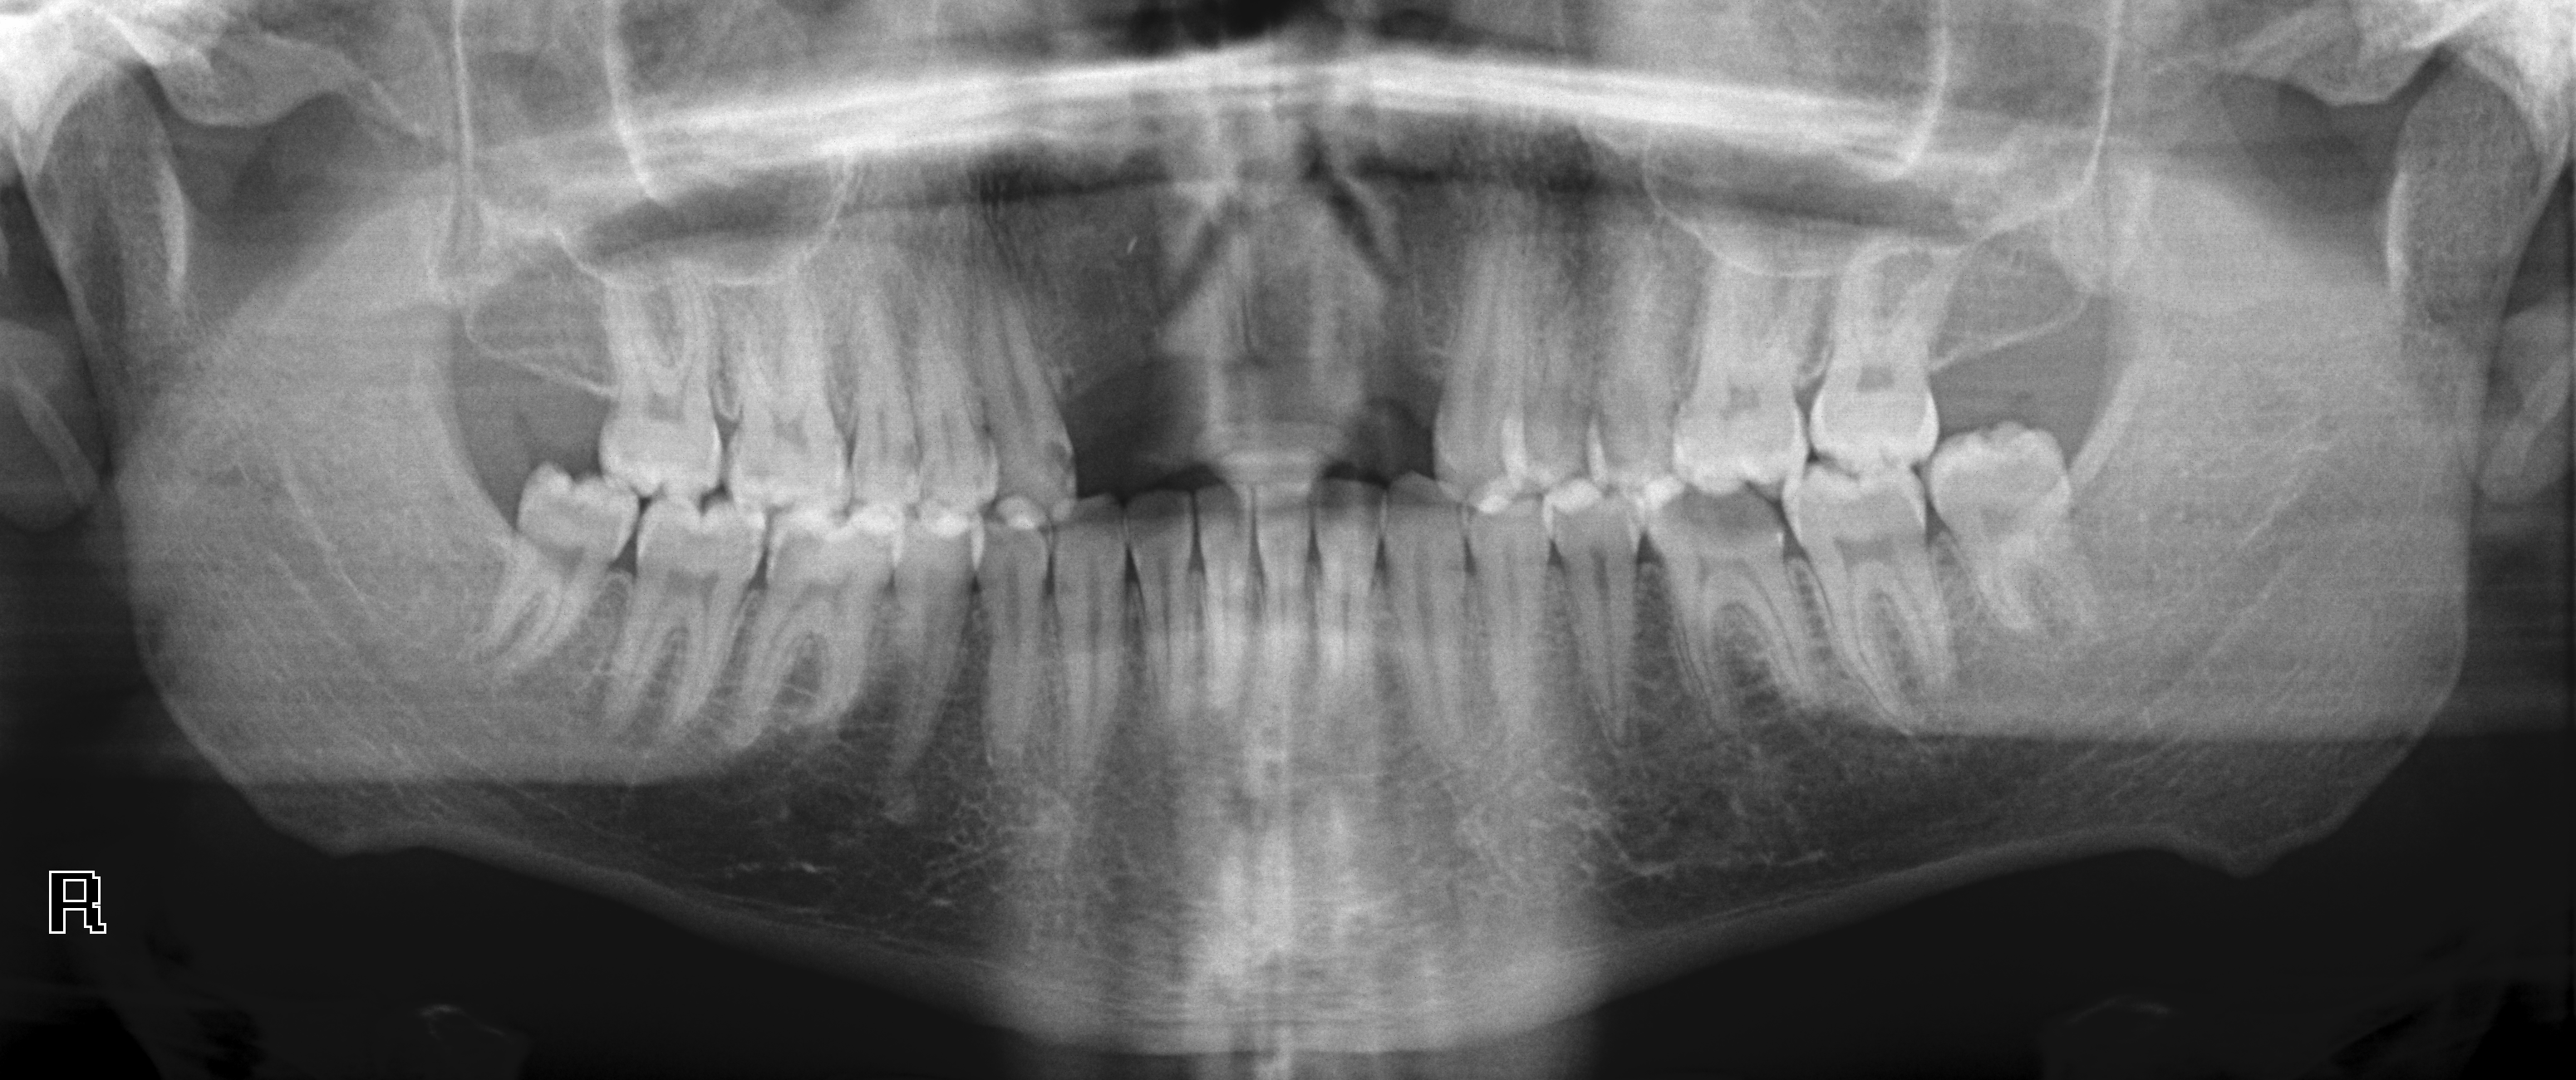

## Scripts
This Jupyter notebook is the starting point for this tutorial, where it shows you how to install `pycad`, how to download the dataset and make it ready for training. Then you can start training the model using the script `train.py` then test the model using the script `test.py`.

## Installation
For this tutorial, you need to install pycad-medic which is the core of this tutorial and ultralytics that will be used to train YOLOv8.
```
pip install -q pycad-medic
```
```
pip install ultralytics==8.0.142
```

***Important note:*** this tutorial requires the version 0.0.8 or greater, so if you have lower version please consider upgrading the version using `pip install -U pycad-medic`.

## *Disclamaire*
Please consider reading the whole notebook, there are several useful information about the project.

---

### Download the dataset
For now (v0.0.8), as 2D image segmentation datasets, there is only PanMandibleDataset that is available which is a set of 116 panoramic xray and the masks for mandible. You can explore all the available datasets [here](https://drive.google.com/drive/folders/1pLw1miF2AHZW8V64RTnhk4v63ZYEwx7G?usp=sharing).

In [ ]:
from pycad.datasets.segmentation.diverse import PanMandibleDataset

In [ ]:
dataset_downloader = PanMandibleDataset()
dataset_downloader.download('all')

### Mask to Polygone
You can use the pycad library to convert your mask images into txt polygones. For more information you can check the documentation [here](https://github.com/amine0110/pycad/blob/main/docs/datasets/png_to_txt_mc.md).

In [ ]:
from pycad.datasets import PngToTxtConverterMC

In [ ]:
input_folder = '/content/datasets/xray_panoramic_mandible/masks'
output_folder = '/content/datasets/xray_panoramic_mandible/txt'
converter = PngToTxtConverterMC(input_folder, output_folder, 0.001) # lets use a coeff of .1%

converter.run()

### Train-Valid Splitter
With pycad you can also do the split to train and valid, you can see the [documentation](https://github.com/amine0110/pycad/blob/main/docs/datasets/data_splitter.md) for more information about this.

In [ ]:
from pycad.datasets import DataSplitter

In [ ]:
img = '/content/datasets/xray_panoramic_mandible/images'
msk = '/content/datasets/xray_panoramic_mandible/txt'
output = '/content/datasets/xray_panoramic_mandible/yolo'

splitter = DataSplitter(img, msk, output, 0.8, 0.2, 0.0, delete_input=False)
splitter.run()

### Dataset.yaml
You don't know how to create the `dataset.yaml` file to train your YOLOv8 model? Pycad got you there! And the [documentation](https://github.com/amine0110/pycad/blob/main/docs/datasets/yolo_dataset_yaml.md) is here for you.

In [ ]:
from pycad.datasets import YOLODatasetYaml

In [ ]:
path_train = '/content/datasets/xray_panoramic_mandible/yolo/train'
path_valid = '/content/datasets/xray_panoramic_mandible/yolo/valid'

config = YOLODatasetYaml(path_train, path_valid, 1, "mandible")
config.create_yaml("./datasets/xray_panoramic_mandible/yolo/dataset.yaml")



---



# Train the model
This section is for training the model for mandible segmentation from panoramic xrays. For an example, I took YOLOv8 from [Ultralytics](https://github.com/ultralytics) with the small architecture.

In [ ]:
import os
from ultralytics import YOLO

In [ ]:
model = YOLO('yolov8s-seg.yaml').load('yolov8s.pt')   # load a pretrained model (recommended for training)

# Train the model
dataset_path = "/content/datasets/xray_panoramic_mandible/yolo/dataset.yaml"
results = model.train(data=dataset_path, epochs=100, imgsz=640, batch=8, patience=30,
                    lr0=.01, lrf=.002, momentum=.937, weight_decay=.0005, warmup_epochs=3.0,
                    warmup_momentum=0.8, warmup_bias_lr=.1, box=7.5, cls=.5, dfl=1.5, pose= 12.0,
                    kobj=1.0, label_smoothing=0.0, nbs=64, hsv_h=.015, hsv_s=.7, hsv_v=.4, degrees=.0,
                    translate=.1, scale=.0, shear=.0, perspective=.0, flipud=.5, fliplr=.5, mosaic=.0,
                    mixup=.0, copy_paste=.3
                    )

---

# Inference
After training the model, we can do the inference now, and show the predictions using OpenCV.
If you want to use the pretrained model directly without redoing the training, please download the model weights [here](https://drive.google.com/file/d/1G7SXOhHpl1boZpdORi1mMKAmLG70uPuC/view?usp=sharing).



In [ ]:
from ultralytics import YOLO
import cv2
import torch
import numpy as np
import os

In [ ]:
# If you are using Google Colab, then include the cv2_imshow
from google.colab.patches import cv2_imshow

In [ ]:
model = YOLO('/content/runs/segment/train3/weights/best.pt')
img_path = '/content/0003.png'
output_dir = os.path.join('./dataset/yolo_predictions', os.path.basename(img_path).split('.')[0])
os.makedirs('./dataset/yolo_predictions', exist_ok=True)

In [ ]:
results = model.predict(source=img_path, conf=0.5, save=False, save_txt=False)
masks = results[0].masks
boxes = results[0].boxes

In [ ]:
# Read the input image
input_img = cv2.imread(img_path)
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

In [ ]:
# Define the color for the mask (BGR format)
mask_color = (250, 200, 0)  # Green color

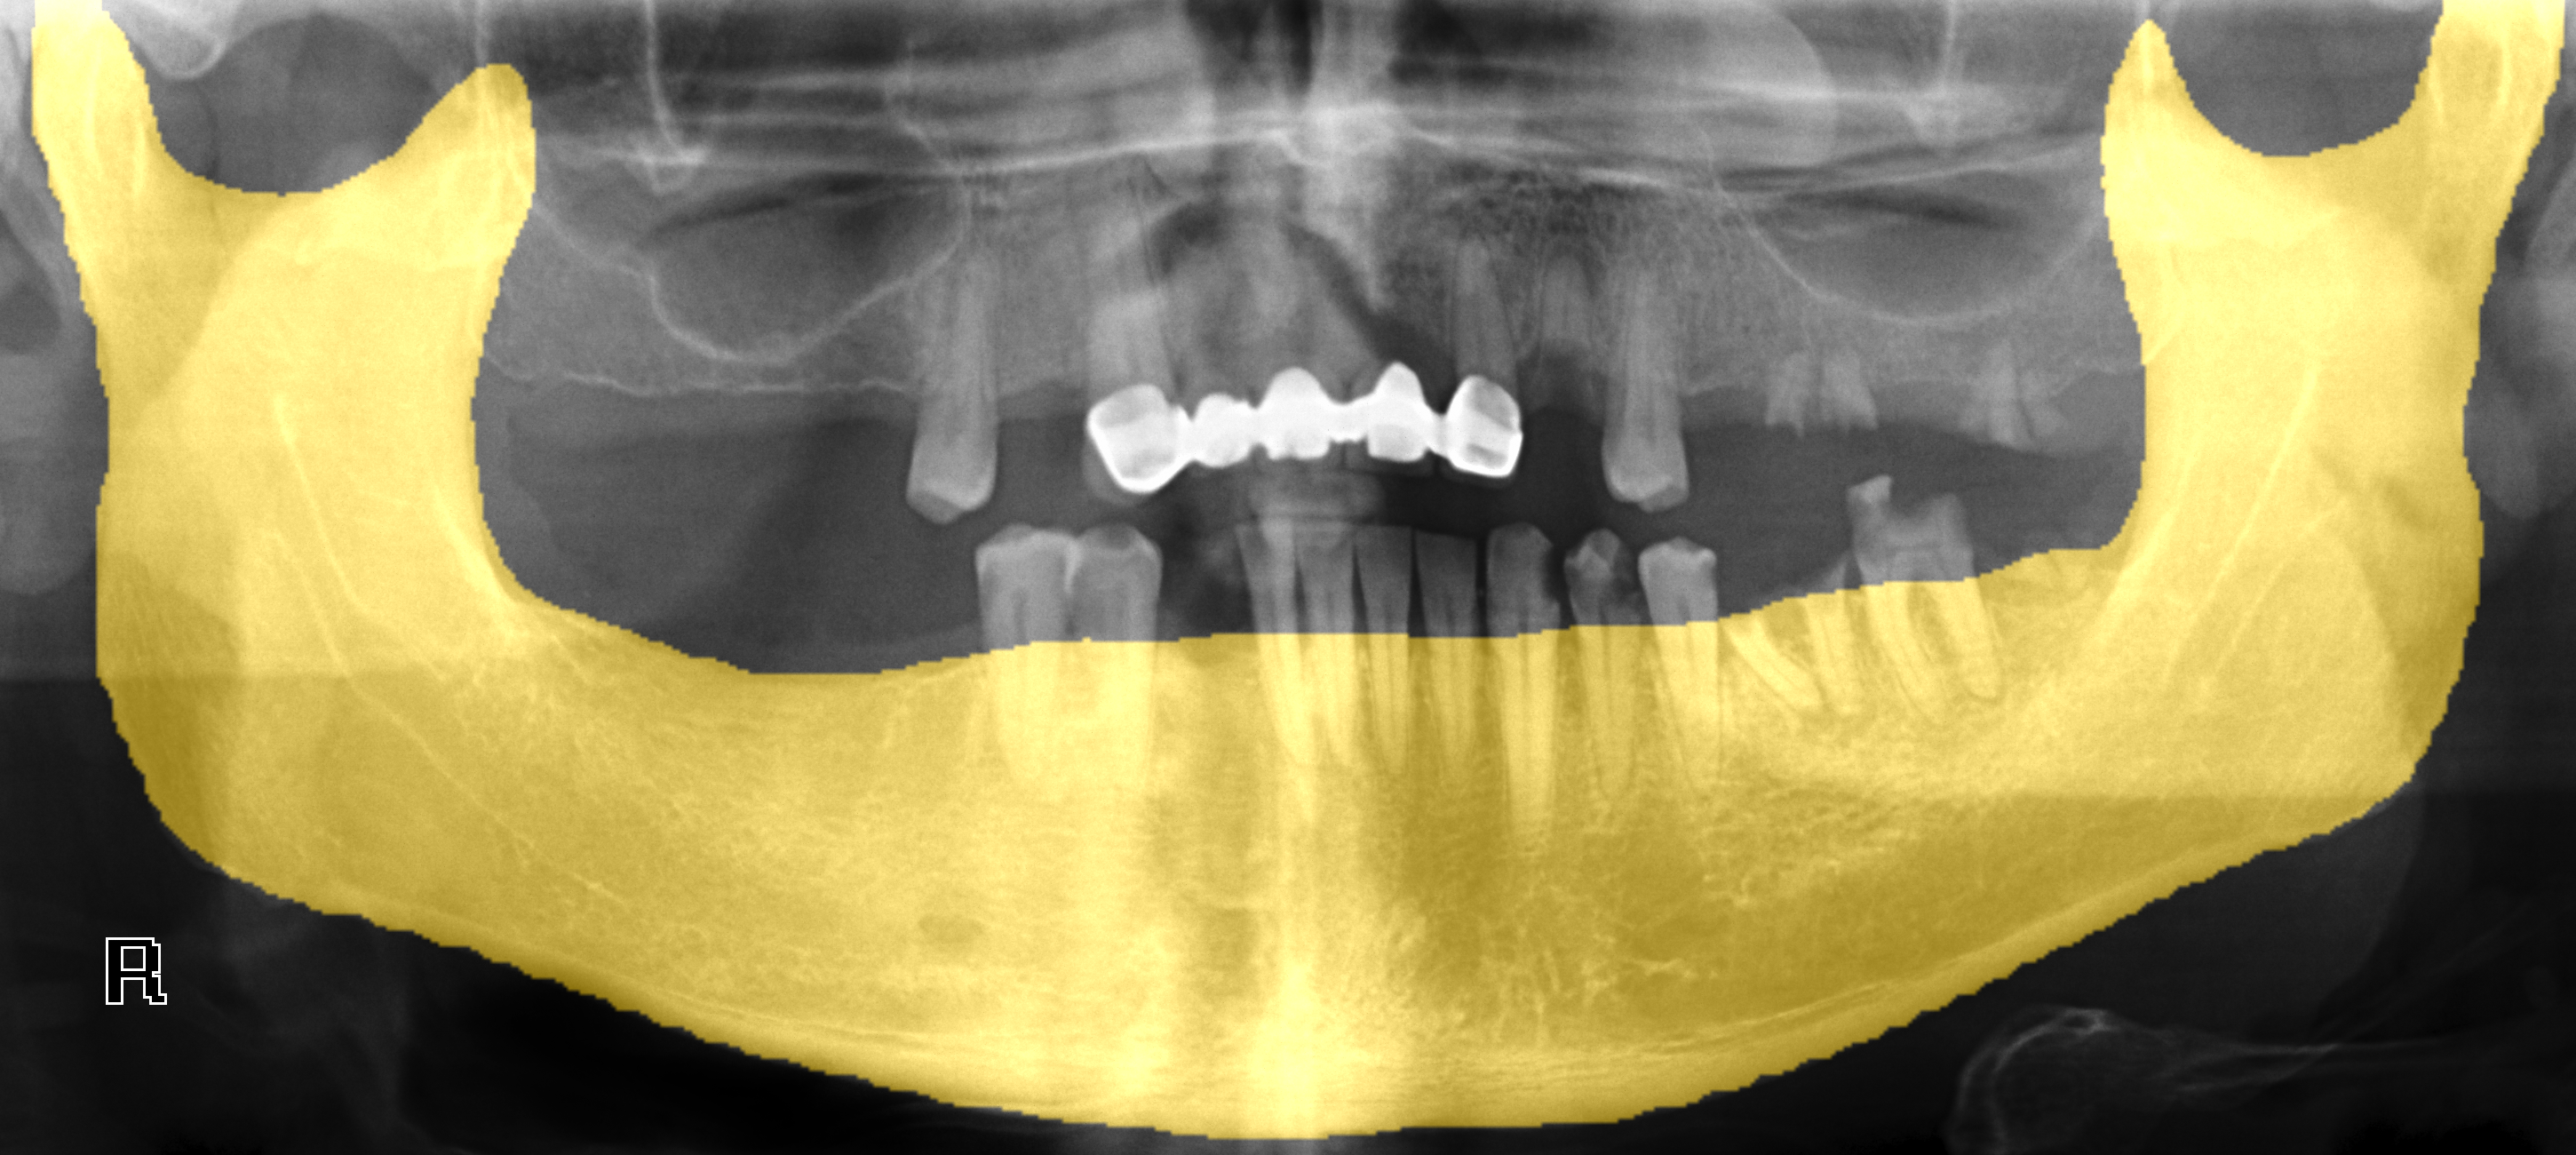

In [ ]:
for idx, mask in enumerate(masks):
    m = torch.squeeze(mask.data)

    # Convert the tensor to numpy array
    mask_np = m.cpu().numpy().astype(np.uint8)

    # Create a colored mask
    colored_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
    colored_mask[mask_np == 1] = mask_color

    # Resize mask to match input image size
    colored_mask = cv2.resize(colored_mask, (input_img.shape[1], input_img.shape[0]))

    # Blend the colored mask with the input image
    alpha = 0.5  # Transparency factor. You can change it as needed.
    overlayed_img = cv2.addWeighted(input_img, 1, colored_mask, alpha, 0)

    # Save the image with overlayed mask
    cv2.imwrite(os.path.join(output_dir, f'mask_overlay_{idx}.png'), cv2.cvtColor(overlayed_img, cv2.COLOR_RGB2BGR))

    # Display the image with overlayed mask
    cv2_imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_RGB2BGR)) # if you are not using Google Colab, then using cv2.imshow instead and add the waiting key.